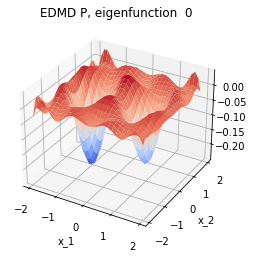

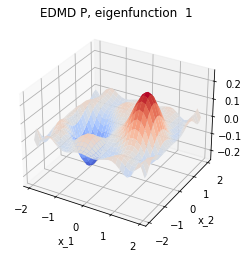

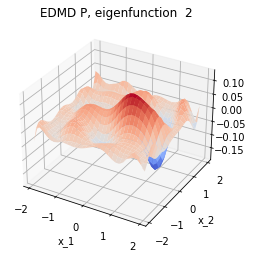

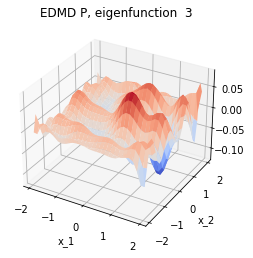

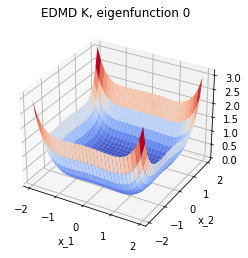

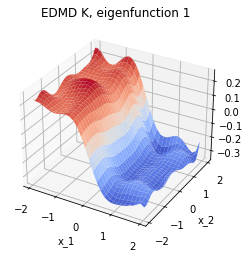

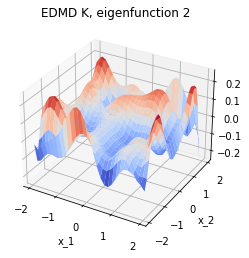

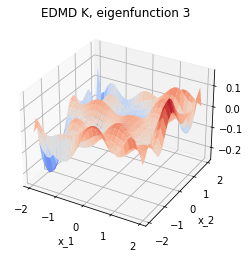

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import scipy
import d3s.domain as domain
import d3s.observables as observables
import d3s.algorithms as algorithms
import d3s.systems as systems

#%% create system

# define domain
bounds = np.array([[-2, 2], [-2, 2]])
boxes = np.array([30, 30])
Omega = domain.discretization(bounds, boxes)

# define system
f = systems.DoubleWell2D(1e-3, 10000)

# generate training data
X = Omega.rand(5000)
Y = f(X) # double-well in two dimensions

# choose observables
psi = observables.monomials(10)
#psi = observables.indicators(Omega)

evs = 4 # number of eigenvalues/eigenfunctions to be computed
PsiC = psi(Omega.midpointGrid()) # observables evaluated at midpoints of the grid

#%% EDMD for Perron-Frobenius operator
_, d, V = algorithms.edmd(X, Y, psi, operator='P', evs=evs)
for i in range(evs):
    plt.figure()
    r = np.real(V[:,i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('EDMD P, eigenfunction  %d' % i)

#%% EDMD for Koopman operator    
_, d, V = algorithms.edmd(X, Y, psi, operator='K', evs=evs)
for i in range(evs):
    plt.figure()
    r = np.real(V[:,i].T @ PsiC)
    Omega.plot(r, '3D')
    plt.title('EDMD K, eigenfunction %d' % i)

In [18]:
# このセルはいじる必要なし

# 2変数での辞書を考える際に必要なパターンを作成する。
# 例えば 2nd order まで考える場合には
# H_2(x_1)*H_0(x_2), H_1(x_1)*H_1(x_2), H_0(x_1)*H_2(x_2)
# を考える必要がある。このとき [2,0] [1,1] [0,2] といった配列を作る必要がある。
# 二次元と決まっていれば簡単だが、高次元に対しても適用可能な方法。
from scipy.special import comb
def next_monomial_powers(c, dim):
    '''
    Make a next list for multivariate monomials.

    This implementation is based on John Burkardt's MONOMIAL toolbox.
    https://people.sc.fsu.edu/~jburkardt/py_src/monomial/monomial.html
    '''
    j = 0
    for i in range(1, dim):
        if 0 < c[i]:
            j = i
            break
    if j == 0:
        t = c[0]
        c[0] = 0
        c[dim-1] = t + 1
    elif j < (dim-1):
        c[j] = c[j] - 1
        t = c[0] + 1
        c[0] = 0
        c[j-1] = c[j-1] + t
    elif j == (dim-1):
        t = c[0]
        c[0] = 0
        c[j-1] = t + 1
        c[j] = c[j] - 1
    return c

def make_monomial_powers(d, p):
    '''
    Calculate all indices for monomials in d dimensions up to p-th order.
    '''
    n = comb(d+p, p, exact=True) # number of monomials
    x = np.zeros(d, dtype=int) # vector containing powers for the monomials, initially zero
    c = []
    c.append(x.copy())
    for i in range(1, n):
        x = next_monomial_powers(x,d)
        c.append(np.flip(x.copy()))
    return np.array(c)

class hermite(object):
    '''
    Compute Hermite dictionaries in d dimensions.
    '''
    def __init__(self, p):
        '''
        The parameter p defines the maximum order of the Hermite function.
        '''
        self.order = p

    def __call__(self, x):
        '''
        Evaluate dictionaries up to order p for a data point.
        '''
        d = x.shape[0]
        list_exponent = make_monomial_powers(d, self.order)
        result_powers = eval_hermite(list_exponent, x)
        vec_psi = np.prod(result_powers, axis=1)
        return vec_psi[:,np.newaxis]

class monomials(object):
    '''
    Compute monomials in d dimensions.
    '''
    def __init__(self, p):
        '''
        The parameter p defines the maximum order of the monomials.
        '''
        self.order = p

    def __call__(self, x):
        '''
        Evaluate all monomials up to order p for a data point.
        '''
        d = x.shape[0]
        list_exponent = make_monomial_powers(d, self.order)
        result_powers = np.power(x, list_exponent)
        vec_psi = np.prod(result_powers, axis=1)
        return vec_psi[:,np.newaxis]

In [12]:
# このセルもいじる必要なし。EDMDの定義（ただしWilliams論文とは少し違う）

# Define the main routine for EDMD
def edmd(X, Y, psi):
    '''
    EDMD algorithm. The inputs are the matricies X and Y for the snapshot pairs.
    
    :param psi:      Basis functions, which will be given as a class object.
    :return:         Koopman matrix K.
    '''
    # Check the size of dictionaries
    m = psi(X[0]).shape[0]
    A = np.zeros([m,m])
    G = np.zeros([m,m])
    for x, y in zip(X, Y):
        psi_x = psi(x)
        psi_y = psi(y)
        A = A + psi_y @ psi_x.T
        G = G + psi_x @ psi_x.T
    K = A @ scipy.linalg.pinv(G)
    return K
def sortEig(A, evs=5, which='LM'):
    '''
    Computes eigenvalues and eigenvectors of A and sorts them in decreasing lexicographic order.

    :param evs: number of eigenvalues/eigenvectors
    :return:    sorted eigenvalues and eigenvectors
    '''
    n = A.shape[0]
    if evs < n:
        #左固有ベクトルを求める
        d, V = _sp.sparse.linalg.eigs(A.T, evs, which=which)
        V = np.conjugate(V).T
        #d, V = _sp.linalg.eig(A, left=True, right=False)
    else:
        d, V = _sp.linalg.eig(A)
    ind = d.argsort()[::-1] # [::-1] reverses the list of indices
    return (d[ind], V[ind, :])

In [19]:
A_k = edmd(X, Y, psi=monomials(3))
d, V = sortEig(A_k, evs=5, which='LM')
#print(V_k.shape)
for i in range(evs):
    plt.figure()
    r = np.real(PsiC.T @ V_k[i, :])
    Omega.plot(r, '3D')
    plt.title('EDMD K, eigenfunction %d' % i)

KeyboardInterrupt: 